In [1]:
from transformers import DefaultDataCollator
import torch
from torchvision import transforms
from transformers import ViTModel, ViTFeatureExtractor, AutoTokenizer, AutoModel, ViTImageProcessor, TrainingArguments, Trainer, DefaultDataCollator
from PIL import Image
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch import nn
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

### Data Load

In [2]:
from datasets import load_dataset
import aiohttp

# Test, Val pair set ==>  lmms-lab/VQAv2

dataset = load_dataset("HuggingFaceM4/VQAv2", trust_remote_code=True,
                      storage_options={'client_kwargs': {'timeout': aiohttp.ClientTimeout(total=36000)}},  # FSTimeout 방지
                       cache_dir = "/home/user/10TB/.cache/huggingface/datasets"
                      )

print(dataset)

Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'image'],
        num_rows: 443757
    })
    validation: Dataset({
        features: ['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'image'],
        num_rows: 214354
    })
    testdev: Dataset({
        features: ['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'image'],
        num_rows: 107394
    })
    test: Dataset({
        features: ['question_type', 'multiple_choice_answer', 'answers', 'image_id', 'answer_type', 'question_id', 'question', 'image'],
        num_rows: 447793
    })
})


In [5]:
dataset['train'][2025]

{'question_type': 'none of the above',
 'multiple_choice_answer': 'no',
 'answers': [{'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'no', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 262727,
 'answer_type': 'yes/no',
 'question_id': 262727001,
 'question': 'Can the cat talk to you?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640>}

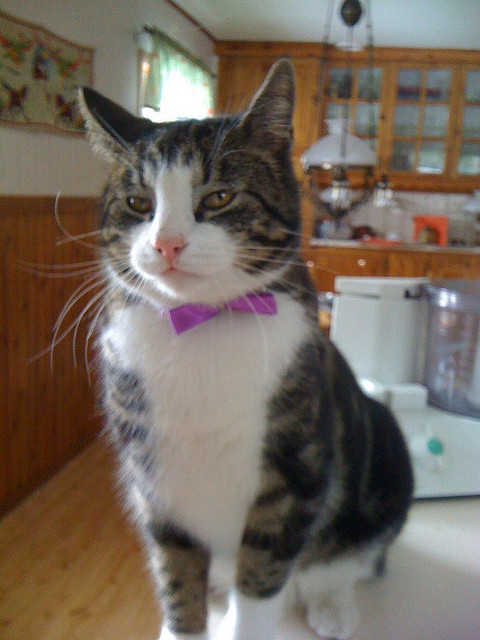

In [6]:
dataset['train'][2025]['image']

### Label 만들기

In [18]:
import pandas as pd
from collections import Counter


#  모든 multiple_choice_answer 값 추출
answers = dataset['train']['multiple_choice_answer']

#  정답 빈도수 계산
answer_counts = Counter(answers)

# 가장 많이 등장한 Top-K 정답 선택, followed by ViLT 
top_k = 3129
top_answers = [answer for answer, count in answer_counts.most_common(top_k)]

# 정답을 인덱스로 변환 (Label Encoding)
answer_to_index = {answer: idx for idx, answer in enumerate(top_answers)}

# 반대로 매핑하여 ids_to_answer 생성
ids_to_answer = {idx: answer for answer, idx in answer_to_index.items()}
ids_to_answer[3129] = "[UNK]"


#  데이터셋 변환: 정답을 인덱스로 매핑
# encoded_data = [
#     {"multiple_choice_answer": item["multiple_choice_answer"], 
#      "encoded_label": answer_to_index.get(item["multiple_choice_answer"], -1)}  # 사전에 없는 정답은 -1 처리
#     for item in data
# ]

#  결과 출력
print("Top-K Answers:", top_answers)
print("Answer to Index Mapping:", answer_to_index)

Top-K Answers: ['yes', 'no', '1', '2', 'white', '3', 'blue', 'red', 'black', '0', '4', 'brown', 'green', 'yellow', '5', 'gray', 'nothing', 'right', 'frisbee', 'baseball', 'left', 'none', 'tennis', '6', 'wood', 'orange', 'bathroom', 'pizza', 'pink', 'kitchen', '10', '7', 'cat', '8', 'dog', 'water', 'man', 'skateboarding', 'grass', 'skiing', 'kite', 'silver', 'black and white', 'surfing', 'horse', 'living room', 'skateboard', 'phone', 'snow', 'wii', 'giraffe', 'woman', 'standing', 'surfboard', 'eating', 'cake', 'food', 'apple', 'sunny', 'broccoli', 'table', 'hat', 'stop', 'purple', 'laptop', 'elephant', '12', 'sheep', '9', 'snowboarding', 'train', 'beach', 'motorcycle', 'soccer', 'banana', 'bus', 'cow', 'male', 'trees', 'walking', 'umbrella', 'winter', '20', 'wine', 'sitting', 'flowers', 'bear', 'camera', 'female', 'tile', 'metal', 'clear', 'tan', 'many', 'outside', 'brick', 'car', 'plane', '11', 'sandwich', 'donut', 'summer', 'night', 'bananas', 'bed', 'down', 'cloudy', 'zebra', 'hot do

### Processor

In [8]:
# Define the image and text models
img_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

In [9]:
def preprocess_data(examples):
   # image_paths = examples['image_id']
   # images = [Image.open(image_path) for image_path in image_paths]
    img = examples['image']
    texts = examples['question']

    encoding = tokenizer(texts,
                        padding="max_length",
                         truncation=True,
                         max_length=512,
                         return_tensors="pt",
                        )
    

    # 모든 이미지가 RGB인지 확인 후 변환
    if img.mode != "RGB":
        img = img.convert("RGB") 

    # add pixel_values + pixel_mask
    encoding_image_processor = img_processor(img, return_tensors="pt")
    encoding.update(encoding_image_processor)

    for k, v in encoding.items():
          encoding[k] = v.squeeze()

    encoding["labels"] = answer_to_index.get(examples["multiple_choice_answer"], 3129)

    return encoding

In [10]:
processed__train = dataset['train'].flatten().map(preprocess_data,
                                     batched=False,
                                     remove_columns=['question_type',  'question_id', 'image_id', 
                                                     'answer_type', 'answers', 'image', 'question', 'multiple_choice_answer'],
                                    )
processed__valid = dataset['validation'].flatten().map(preprocess_data,
                                     batched=False,
                                     remove_columns=['question_type',  'question_id', 'image_id', 
                                                     'answer_type', 'answers', 'image', 'question', 'multiple_choice_answer'],
                                    )

Map:   0%|          | 0/4287 [00:00<?, ? examples/s]

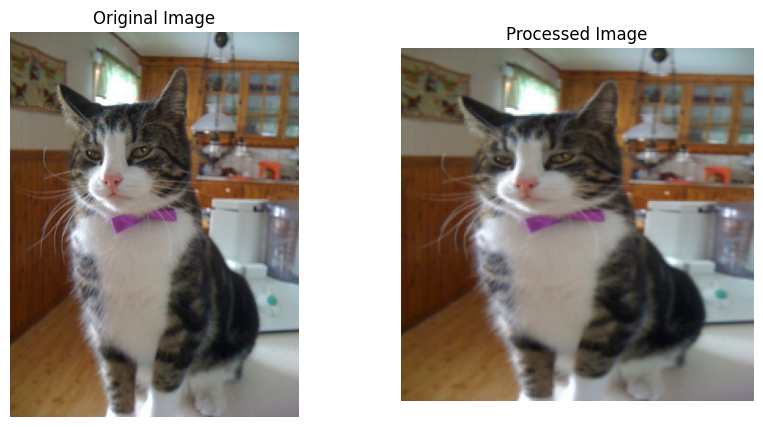

<class 'PIL.JpegImagePlugin.JpegImageFile'> <class 'torch.Tensor'>
RGB (480, 640) torch.Size([224, 224, 3])


In [12]:
import torch
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor
from PIL import Image
import requests

image = dataset['train'][2025]['image']

# ViTImageProcessor 초기화
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

# 이미지 전처리
processed_image = processor(image, return_tensors="pt")["pixel_values"][0]
# matplotlib.pyplot.imshow()는 일반적인 이미지 형식인 (H, W, C) 형식을 기대
processed_image = processed_image.permute(1, 2, 0)  # (C, H, W) -> (H, W, C)

# 정규화된 이미지는 [-1,1] 범위를 가질 수 있으므로, [0,1] 범위로 변환
processed_image = (processed_image - processed_image.min()) / (processed_image.max() - processed_image.min())

# 이미지 비교
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(processed_image)
axes[1].set_title("Processed Image")
axes[1].axis("off")

plt.show()
print(type(image), type(processed_image))
print(image.mode, image.size, processed_image.shape)

### Train the model

In [28]:
class QuestionAnsweringModel(nn.Module):
    def __init__(self, text_model, image_model, num_labels, hidden_size=768, projection_dim=768,):
        super().__init__()
        self.projection_dim = projection_dim
        self.num_labels = num_labels
        self.hidden_size = hidden_size
        
        self.text_model = AutoModel.from_pretrained(text_model)
        self.image_model = AutoModel.from_pretrained(image_model)

        self.vqahead = nn.Sequential(
            nn.Linear(self.hidden_size * 2, self.hidden_size * 2),
            nn.LayerNorm(self.hidden_size * 2),
            nn.GELU(),
            nn.Linear(self.hidden_size * 2, self.num_labels),
        )

    def forward(
        self,
        input_ids = None, attention_mask = None, token_type_ids = None, text_output_attentions = None, text_output_hidden_states = None,
        pixel_values = None, head_mask = None, img_output_attentions = None, img_output_hidden_states = None, interpolate_pos_encoding = None,
        return_dict = None,
        labels = None
    ):

        
        text_out = self.text_model(
                input_ids = input_ids,
                attention_mask = attention_mask,
                token_type_ids = token_type_ids,
                output_attentions = text_output_attentions,
                output_hidden_states = text_output_hidden_states,
                return_dict=return_dict,
            )
        img_out = self.image_model(
            pixel_values = pixel_values,
            head_mask=head_mask,
            output_attentions=img_output_attentions,
            output_hidden_states=img_output_hidden_states,
            interpolate_pos_encoding=interpolate_pos_encoding,
            return_dict=return_dict,
        )

    
        # get pooled output([CLS] Token)
        text_embeds = text_out[0][:,0,:]
        img_embeds = img_out[0][:,0,:]

     #   print("text: ", text_embeds.shape, text_embeds)
    #    print("image: ", img_embeds.shape, img_embeds)

        concated_input = torch.concat([text_embeds, img_embeds], dim=1)  # [Batch_size, hidden * 2 (768 * 2)] 

     #   print("concated: ", concated_input.shape)

        logits = self.vqahead(concated_input)

        loss = None

        if labels != None:
            loss_fct = nn.CrossEntropyLoss()
    
           # loss_fct = loss_fct(logits_O.view(-1, self.num_labels), labels[0])
            loss = loss_fct(logits.squeeze(), labels.squeeze())

        # dict 처리하기?
        return loss, logits

In [14]:
model = QuestionAnsweringModel('FacebookAI/roberta-base','google/vit-base-patch16-224-in21k', num_labels=3130)

data_collator = DefaultDataCollator()

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir = "/home/user/10TB/egg2018037024/vqa/",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    per_device_train_batch_size=2,
    per_device_eval_batch_size = 2,
    num_train_epochs=10,
    learning_rate=5e-5,
)


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=processed__train,
    eval_dataset = processed__valid,
    processing_class=processor,
)

In [ ]:
trainer.train()

### Inference

In [29]:
from safetensors.torch import load_model

img_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/roberta-base')

image = dataset['testdev'][0]['image']
question = dataset['testdev'][0]['question']

# prepare inputs
input_image = img_processor(image, return_tensors="pt")
inputs = tokenizer(question, 
                       padding="max_length",
                         truncation=True,
                         max_length=512,
                         return_tensors="pt",
                        )

inputs.update(input_image)

model = QuestionAnsweringModel('FacebookAI/roberta-base','google/vit-base-patch16-224-in21k', num_labels=3130)

load_model(test_model, "/home/user/10TB/egg2018037024/vqa/checkpoint-837/model.safetensors")


# forward pass
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs[1]
idx = logits.argmax(-1).item()
print("Predicted answer:", ids_to_answer[idx])

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted answer: bat
